<a href="https://colab.research.google.com/github/Ebasurtos/MISTI/blob/main/Desarrollo_de_Sensor_Virtual_(Stacked_LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desarrollo de Sensor Virtual (Soft-Sensor) para Predicción de Sílice en Concentrado de Hierro" -** ***Basurto,Eder / Díaz, Piero / Palacios, Jorge / Soriano, Richard***  


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Escaneando estructura del archivo...
Rango total escaneado: 2017-03-10 01:00:00 a 2017-09-09 23:00:00

--- ANALIZANDO PERIODOS CONTINUOS (Buscando Golden Batches) ---
 Segment_ID               Start                 End  Duration_Days  Total_Rows
          4 2017-06-15 01:00:00 2017-07-24 01:00:00             39      168660
          6 2017-08-15 01:00:00 2017-09-09 16:00:00             25      110880
          1 2017-03-29 12:00:00 2017-04-21 07:00:00             22       98639
          2 2017-04-24 07:00:00 2017-05-09 16:00:00             15       66600
          0 2017-03-10 07:00:00 2017-03-16 01:00:00              5       25020


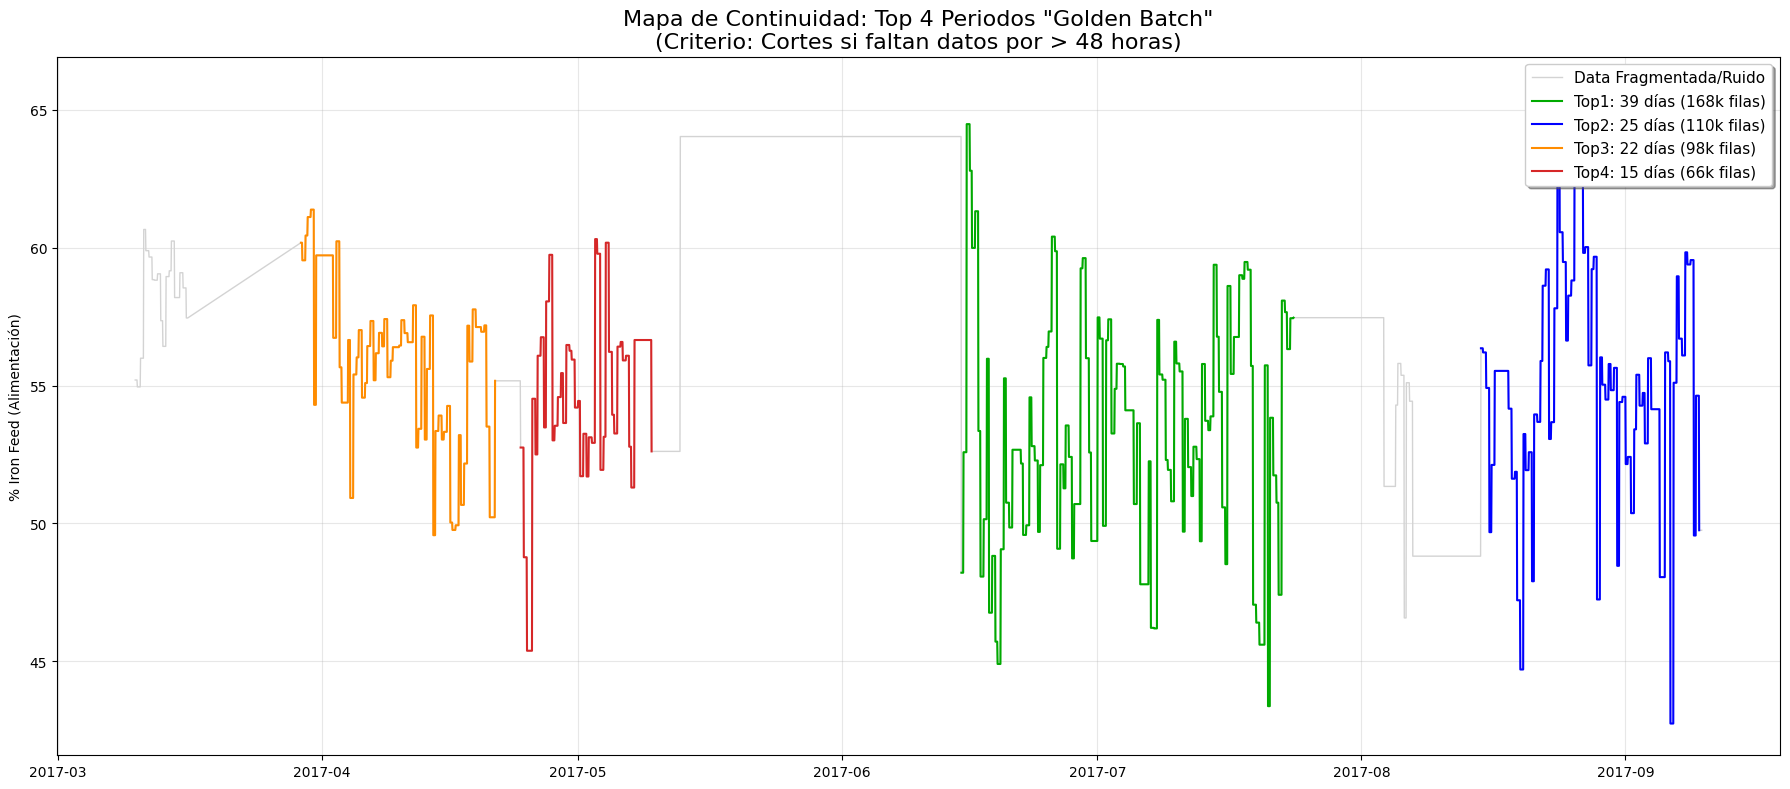

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gc
from google.colab import drive

drive.mount('/content/drive')

# 1. Carga Ligera (Solo fechas y variable crítica para no gastar RAM)
FILE_PATH = "/content/drive/MyDrive/MISTI/Project/MiningProcess_Flotation_Plant_Database.csv"

print("Escaneando estructura del archivo...")
# Cargamos solo lo necesario
df_scan = pd.read_csv(FILE_PATH, decimal=',', parse_dates=['date'], index_col='date', usecols=['date', '% Iron Feed'])
df_scan = df_scan.sort_index()

print(f"Rango total escaneado: {df_scan.index.min()} a {df_scan.index.max()}")

# 2. Detección de 'Cortes' (Gaps)
# Si el sensor se queda pegado o no reporta por más de 48 horas, cortamos el segmento.
MAX_GAP_HOURS = 48

# Detectar cambios reales (valor cambia > 0.0001)
df_scan['value_changed'] = df_scan['% Iron Feed'].diff().abs() > 0.0001
updates = df_scan[df_scan['value_changed']].index.to_series()

# Calcular tiempo entre actualizaciones
time_between_updates = updates.diff()

# Identificar cortes (> 48h sin data nueva)
cuts = time_between_updates > pd.Timedelta(hours=MAX_GAP_HOURS)
segment_id = cuts.cumsum()

# 3. Análisis de Segmentos
results = []
print("\n--- ANALIZANDO PERIODOS CONTINUOS (Buscando Golden Batches) ---")

for i in segment_id.unique():
    seg_dates = updates[segment_id == i]
    if len(seg_dates) < 2: continue

    start_date = seg_dates.min()
    end_date = seg_dates.max()
    duration = end_date - start_date

    # Contar filas totales en ese rango (aprox)
    row_count = len(df_scan[start_date:end_date])

    results.append({
        'Segment_ID': i,
        'Start': start_date,
        'End': end_date,
        'Duration_Days': duration.days,
        'Total_Rows': row_count
    })

# Ordenar por cantidad de datos (De mayor a menor)
df_segments = pd.DataFrame(results).sort_values('Total_Rows', ascending=False)

# Mostrar Tabla del Top 5
print(df_segments.head(5).to_string(index=False))

# 4. Visualización (Coloreando el Top 4)
plt.figure(figsize=(18, 8)) # Hacemos el gráfico más ancho

# Fondo gris: Toda la data (incluida la mala)
plt.plot(df_scan.index, df_scan['% Iron Feed'], color='lightgray', label='Data Fragmentada/Ruido', linewidth=1)

# Colores para el Top 4
colors = ['#00aa00', '#0000ff', '#ff8c00', '#d62728'] # Verde, Azul, Naranja, Rojo
labels = ['Top1', 'Top2', 'Top3', 'Top4']

# Pintar los ganadores
for idx, (i, row) in enumerate(df_segments.head(4).iterrows()):
    subset = df_scan[row['Start']:row['End']]
    plt.plot(subset.index, subset['% Iron Feed'], color=colors[idx],
             label=f"{labels[idx]}: {row['Duration_Days']} días ({int(row['Total_Rows']/1000)}k filas)",
             linewidth=1.5)

plt.title(f'Mapa de Continuidad: Top 4 Periodos "Golden Batch"\n(Criterio: Cortes si faltan datos por > {MAX_GAP_HOURS} horas)', fontsize=16)
plt.ylabel('% Iron Feed (Alimentación)')
plt.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

El Segmento #4 (Top 1) es el ganador indiscutible: 39 días continuos desde el 15 de Junio hasta el 24 de Julio. Esto representa casi 170,000 registros de alta calidad, lo cual es más que suficiente para entrenar un modelo de Deep Learning robusto sin tener que lidiar con los huecos masivos de mayo o agosto

## **Bloque 1: Configuración y Carga (Data Understanding)**

El objetivo de esta sección es establecer la conexión con el repositorio de datos (Google Drive) y realizar una carga inicial. Dado que el proceso minero es continuo, se utiliza la fecha como índice temporal.

In [14]:
# ==========================================
# FINAL STEP: LOADING THE GOLDEN BATCH (Rank #1)
# ==========================================
import gc

# Define the Winner Dates (Segment 4 from your analysis)
START_DATE = '2017-06-15 01:00:00'
END_DATE   = '2017-07-24 01:00:00'

print(f"Loading Golden Batch Data...")
print(f"Period: {START_DATE} to {END_DATE}")

# 1. Load ONLY the specific time range
# We parse dates and filter immediately
df = pd.read_csv(FILE_PATH, decimal=',', parse_dates=['date'], index_col='date')
df = df.loc[START_DATE : END_DATE].copy()

print(f"Golden Batch Loaded successfully.")
print(f"Dimensions: {df.shape}")

# 2. Lightweight Cleaning (Just interpolation, no heavy filtering needed)
# Since this batch is continuous by definition, we just fix the steps.
print("Applying local interpolation...")

class LightCleaner:
    def __init__(self, df): self.df = df.copy()

    def fix_feed_steps(self, cols):
        for c in cols:
            mask = self.df[c] != self.df[c].shift()
            self.df[c] = self.df[c].where(mask, np.nan).interpolate(method='time').bfill()
        return self.df

    def smooth_sensors(self, cols):
        for c in cols:
            try: self.df[c] = savgol_filter(self.df[c], 15, 2)
            except: pass
        return self.df

cleaner = LightCleaner(df)
df = cleaner.fix_feed_steps(['% Iron Feed', '% Silica Feed'])

sensor_cols = [c for c in df.columns if 'Flow' in c or 'pH' in c or 'Density' in c or 'Level' in c]
df = cleaner.smooth_sensors(sensor_cols)

print("Data is ready for Feature Engineering & Training.")
del cleaner
gc.collect()

Loading Golden Batch Data...
Period: 2017-06-15 01:00:00 to 2017-07-24 01:00:00
Golden Batch Loaded successfully.
Dimensions: (168660, 23)
Applying local interpolation...
Data is ready for Feature Engineering & Training.


4522

## **Bloque 5: Ingeniería de Características (Feature Engineering)**

Para mejorar la capacidad predictiva del modelo, enriquecemos el dataset con variables sintéticas basadas en principios metalúrgicos.
- **Gradiente de pH ($\Delta pH$)**: Captura la cinética química. Un cambio rápido en el pH suele preceder a una inestabilidad en la recuperación.
- **Dosificación Específica**: Normaliza el flujo de reactivos por tonelada de mineral procesado ($m^3/t$), eliminando el sesgo producido por variaciones en el flujo másico.
- **Ventanas Deslizantes**: Agregan "memoria" a las variables de control, permitiendo al modelo entender la tendencia reciente de la operación.

**Nota:** Se contempla un experimento futuro (Ablation Study) para validar estadísticamente el aporte de estas nuevas variables.

In [15]:
# ==========================================
# 5. FEATURE ENGINEERING
# ==========================================

def create_features(df):
    data = df.copy()

    # Gradiente Químico
    data['pH_Gradient'] = data['Ore Pulp pH'].diff().fillna(0)

    # Dosificación Específica (Evitando división por 0)
    data['Specific_Amina'] = data['Amina Flow'] / (data['Ore Pulp Flow'] + 1e-6)
    data['Specific_Starch'] = data['Starch Flow'] / (data['Ore Pulp Flow'] + 1e-6)

    # Memoria Operativa (Rolling Windows - 1 hora)
    data['Amina_Mean_1h'] = data['Amina Flow'].rolling(window=180).mean()
    data['Air_Stability_1h'] = data['Flotation Column 01 Air Flow'].rolling(window=180).std()

    return data.dropna()

df_eng = create_features(df)
print(f"Features listos. Dimensiones Finales: {df_eng.shape}")

# --- LIBERACIÓN DE MEMORIA 3 ---
del df
gc.collect()


Features listos. Dimensiones Finales: (168481, 28)


0

## **Bloque 6: Preparación para Entrenamiento (Batches Secuenciales)**

Este paso es crítico para Deep Learning en series temporales discontinuas:

- **Split Cronológico:** Dividimos Train (80%) y Test (20%) antes de escalar.

- **No Data Leakage:** El escalador (MinMaxScaler) se ajusta solo con el set de entrenamiento.

- **Gestión de Gaps:** La función create_sequences detecta los huecos que creamos en la limpieza (el 32% borrado) y corta la secuencia para no alimentar al modelo con saltos de tiempo irreales.

Creamos los tensores X e y sin que salgan vacíos.
Usamos gap_threshold=60 (tolerancia de 1 hora) y seq_length=90 (30 min de historia).

In [16]:
# ==========================================
# 6. GENERACIÓN DE SECUENCIAS (OPTIMIZADO)
# ==========================================

# 1. Split Cronológico (80% Train / 20% Test)
train_size = int(len(df_eng) * 0.8)
train_df = df_eng.iloc[:train_size]
test_df = df_eng.iloc[train_size:]

print(f"Split -> Train: {train_df.shape[0]} | Test: {test_df.shape[0]}")

# 2. Fit Scaler (SOLO EN TRAIN para evitar Data Leakage)
TARGET = '% Silica Concentrate'
feature_cols = [c for c in df_eng.columns if c != TARGET]

scaler_X = MinMaxScaler().fit(train_df[feature_cols])
scaler_y = MinMaxScaler().fit(train_df[[TARGET]])

# 3. Función Generadora Robusta
def create_sequences(df_part, seq_length=90, gap_threshold_min=60):
    X_seqs, y_seqs = [], []

    # Transformar data
    data_X = scaler_X.transform(df_part[feature_cols])
    data_y = scaler_y.transform(df_part[[TARGET]])

    # Detectar huecos de tiempo (donde borramos data mala)
    time_diffs = df_part.index.to_series().diff().dt.total_seconds() / 60
    # Si el salto es mayor a 60 min, cortamos la secuencia
    breaks = time_diffs > gap_threshold_min
    segment_ids = breaks.cumsum()

    unique_segments = segment_ids.unique()
    print(f"Procesando {len(unique_segments)} segmentos de datos...")

    for seg_id in unique_segments:
        indices = np.where(segment_ids == seg_id)[0]

        # Si el segmento es muy corto, lo saltamos
        if len(indices) <= seq_length:
            continue

        seg_X = data_X[indices]
        seg_y = data_y[indices]

        # Crear ventanas deslizantes
        for i in range(len(seg_X) - seq_length):
            X_seqs.append(seg_X[i : i+seq_length])
            y_seqs.append(seg_y[i+seq_length])

    return np.array(X_seqs), np.array(y_seqs)

# 4. Ejecución
SEQUENCE_LENGTH = 90 # 30 minutos de historia

print("\n--- Generando Train Sequences ---")
X_train, y_train = create_sequences(train_df, seq_length=SEQUENCE_LENGTH)

print("\n--- Generando Test Sequences ---")
X_test, y_test = create_sequences(test_df, seq_length=SEQUENCE_LENGTH)

print(f"\nDimensiones Finales (Tensores):")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}  | y_test:  {y_test.shape}")

# --- LIBERACIÓN DE MEMORIA CRÍTICA ---
del df_eng, train_df, test_df
gc.collect()

Split -> Train: 134784 | Test: 33697

--- Generando Train Sequences ---
Procesando 1 segmentos de datos...

--- Generando Test Sequences ---
Procesando 1 segmentos de datos...

Dimensiones Finales (Tensores):
X_train: (134694, 90, 27) | y_train: (134694, 1)
X_test:  (33607, 90, 27)  | y_test:  (33607, 1)


45

## **Bloque 6: Entrenamiento del Modelo (STACKED LSTM)**

Implementamos la red neuronal recurrente.
- **Arquitectura:** LSTM (64 unidades) + Dropout (0.2) + Dense (32) + Output (1).
- **Estrategia:** El modelo recibe la secuencia de sensores de la última hora ($X_{t-60}...X_t$) y predice la sílice futura ($Y_{t+1}$).
- **Callbacks:** EarlyStopping detiene el entrenamiento si el error de validación deja de bajar, evitando el sobreajuste.

In [17]:
# ==========================================
# 6. MODEL TRAINING - STACKED LSTM
# ==========================================

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Validación de seguridad
if X_train.shape[0] == 0:
    raise ValueError("¡Error! X_train vacío. Revisa SEQUENCE_LENGTH o segmentos.")

# 1. Arquitectura Stacked LSTM
model = Sequential([
    # Primera capa LSTM (aprende dinámica rápida)
    LSTM(
        64,
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ),
    Dropout(0.2),

    # Segunda capa LSTM (aprende dinámica operativa)
    LSTM(
        32,
        return_sequences=False
    ),
    Dropout(0.2),

    # Capa densa de interpretación
    Dense(32, activation='relu'),

    # Salida: Sílice futura
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mse']
)

model.summary()

# 2. Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        'best_stacked_narx.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

# 3. Entrenamiento
print("Entrenando modelo Stacked LSTM...")
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

print("Entrenamiento completado.")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 90, 64)         │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,057 (144.75 KB)

 Trainable params: 37,057 (144.75 KB)

 Non-trainable params: 0 (0.00 B)

Entrenando modelo Stacked LSTM...
Epoch 1/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 196s 361ms/step - loss: 0.1119 - mse: 0.0284 - val_loss: 0.0678 - val_mse: 0.0111
Epoch 2/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 195s 370ms/step - loss: 0.0758 - mse: 0.0124 - val_loss: 0.0992 - val_mse: 0.0181
Epoch 3/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 186s 353ms/step - loss: 0.0698 - mse: 0.0110 - val_loss: 0.0803 - val_mse: 0.0156
Epoch 4/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 191s 363ms/step - loss: 0.0724 - mse: 0.0116 - val_loss: 0.0894 - val_mse: 0.0172
Epoch 5/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 193s 366ms/step - loss: 0.0605 - mse: 0.0085 - val_loss: 0.0892 - val_mse: 0.0166
Epoch 6/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 186s 352ms/step - loss: 0.0548 - mse: 0.0072 - val_loss: 0.0879 - val_mse: 0.0167
Epoch 7/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 203s 354ms/step - loss: 0.0542 - mse: 0.0071 - val_loss: 0.0926 - val_mse: 0.0183
Epoch 8/50
527/527 ━━━━━━━━━━━━━━━━━━━━ 199s 348ms/step - loss: 0.0477 - mse: 0.0057 - val_loss: 0.0921 - val_ms

## **Ver la Verdad (Evaluación)**
Apenas termine de entrenar (o se detenga por Early Stopping), ejecuta este código para visualizar el resultado.
Este bloque hará lo siguiente:
- Generará predicciones con la data de Test (que el modelo nunca vio).Des-escalará los datos para volver a tener Porcentaje de Sílice Real (%).
- Calculará el error real (RMSE) para que sepas qué tan lejos estás (ej. $\pm 0.2\%$).

Generando predicciones sobre el set de prueba...
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step

--- RESULTADOS DEL SOFT SENSOR (Golden Batch) ---
RMSE (Error Cuadrático Medio): 0.4831 %
MAE  (Error Absoluto Medio):   0.3111 %
R2 Score (Ajuste del Modelo):  0.5992


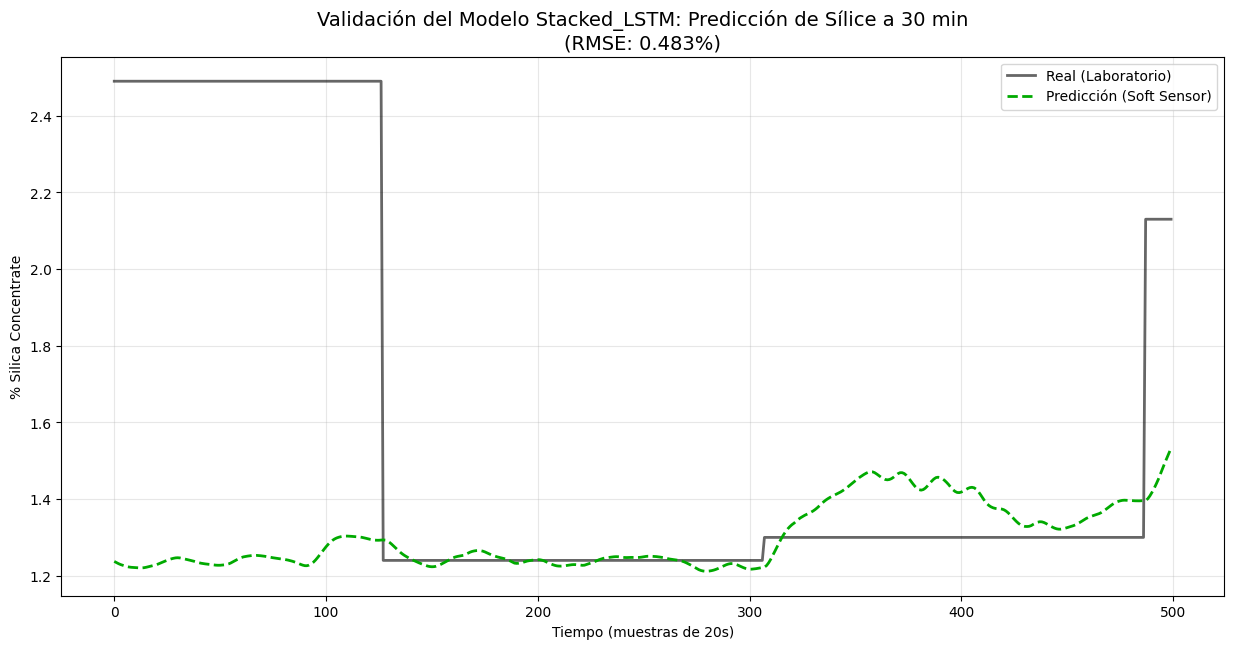

Modelo guardado exitosamente.


In [23]:
# ==========================================
# 8. EVALUACIÓN DE RESULTADOS Y MÉTRICAS
# ==========================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# 1. Generar Predicciones (Usando el modelo recuperado de la mejor época)
print("Generando predicciones sobre el set de prueba...")
y_pred_scaled = model.predict(X_test)

# 2. Invertir el escalado (Volver a % Sílice Real)
# Es vital usar el mismo scaler que usamos al entrenar
y_test_real = scaler_y.inverse_transform(y_test)
y_pred_real = scaler_y.inverse_transform(y_pred_scaled)

# 3. Cálculo de Métricas de Negocio
rmse = math.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae = mean_absolute_error(y_test_real, y_pred_real)
r2 = r2_score(y_test_real, y_pred_real)

print(f"\n--- RESULTADOS DEL SOFT SENSOR (Golden Batch) ---")
print(f"RMSE (Error Cuadrático Medio): {rmse:.4f} %")
print(f"MAE  (Error Absoluto Medio):   {mae:.4f} %")
print(f"R2 Score (Ajuste del Modelo):  {r2:.4f}")

# 4. Visualización: Real vs Predicción (Zoom en 500 muestras)
plt.figure(figsize=(15, 7))

# Graficamos un segmento representativo (aprox 3 horas)
start_idx = 0
end_idx = 500

plt.plot(y_test_real[start_idx:end_idx], label='Real (Laboratorio)', color='black', alpha=0.6, linewidth=2)
plt.plot(y_pred_real[start_idx:end_idx], label='Predicción (Soft Sensor)', color='#00aa00', linestyle='--', linewidth=2)

plt.title(f'Validación del Modelo Stacked_LSTM: Predicción de Sílice a 30 min\n(RMSE: {rmse:.3f}%)', fontsize=14)
plt.ylabel('% Silica Concentrate')
plt.xlabel('Tiempo (muestras de 20s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Guardar el Modelo Final en Drive
model.save('/content/drive/MyDrive/MISTI/Project/best_Staked_LSTM_golden_batch.keras')
print("Modelo guardado exitosamente.")

Agregar una capa de "Semáforo Operativo" eleva tu tesis de un simple ejercicio de modelado a una herramienta de soporte a la toma de decisiones.

No podemos hacer una matriz de confusión clásica sobre la variable continua (el porcentaje exacto), pero SÍ podemos hacerla sobre estas categorías de negocio. Esto demostrará qué tan bueno es el modelo alertando al operador cuando las cosas van mal.

Definición de las Categorías de Negocio
Basándonos en el documento PDF que mencionaste anteriormente:

- Rango Óptimo: 2.9% ≤ Sílice ≤ 3.9% → "Operación Estable"

- Peligro de Penalización: Sílice > 3.9% → "Alerta: Alta Impureza"

- Pérdida de Hierro: Sílice < 2.9% → "Alerta: Baja Recuperación"

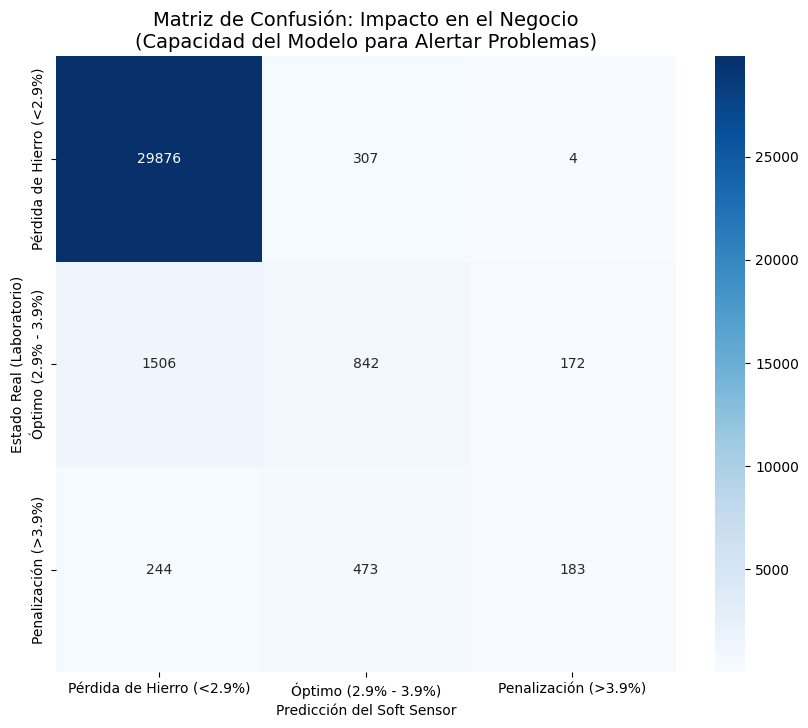


--- REPORTE DE CLASIFICACIÓN OPERATIVA ---
                           precision    recall  f1-score   support

Pérdida de Hierro (<2.9%)       0.51      0.20      0.29       900
     Óptimo (2.9% - 3.9%)       0.94      0.99      0.97     30187
     Penalización (>3.9%)       0.52      0.33      0.41      2520

                 accuracy                           0.92     33607
                macro avg       0.66      0.51      0.55     33607
             weighted avg       0.90      0.92      0.91     33607



In [24]:
# ==========================================
# 9. EVALUACIÓN DE NEGOCIO (SEMÁFORO OPERATIVO)
# ==========================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Definir la Función de Clasificación
def classify_silica(value):
    if value < 2.9:
        return "Pérdida de Hierro (<2.9%)"
    elif value > 3.9:
        return "Penalización (>3.9%)"
    else:
        return "Óptimo (2.9% - 3.9%)"

# 2. Convertir Datos Reales y Predichos a Categorías
# Flatten() convierte las matrices 2D a 1D para poder iterar
y_test_cat = [classify_silica(x) for x in y_test_real.flatten()]
y_pred_cat = [classify_silica(x) for x in y_pred_real.flatten()]

# 3. Generar Matriz de Confusión
labels = ["Pérdida de Hierro (<2.9%)", "Óptimo (2.9% - 3.9%)", "Penalización (>3.9%)"]
cm = confusion_matrix(y_test_cat, y_pred_cat, labels=labels)

# 4. Visualización Profesional
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión: Impacto en el Negocio\n(Capacidad del Modelo para Alertar Problemas)', fontsize=14)
plt.xlabel('Predicción del Soft Sensor')
plt.ylabel('Estado Real (Laboratorio)')
plt.show()

# 5. Reporte de Clasificación (Precisión por Categoría)
print("\n--- REPORTE DE CLASIFICACIÓN OPERATIVA ---")
print(classification_report(y_test_cat, y_pred_cat, target_names=labels))

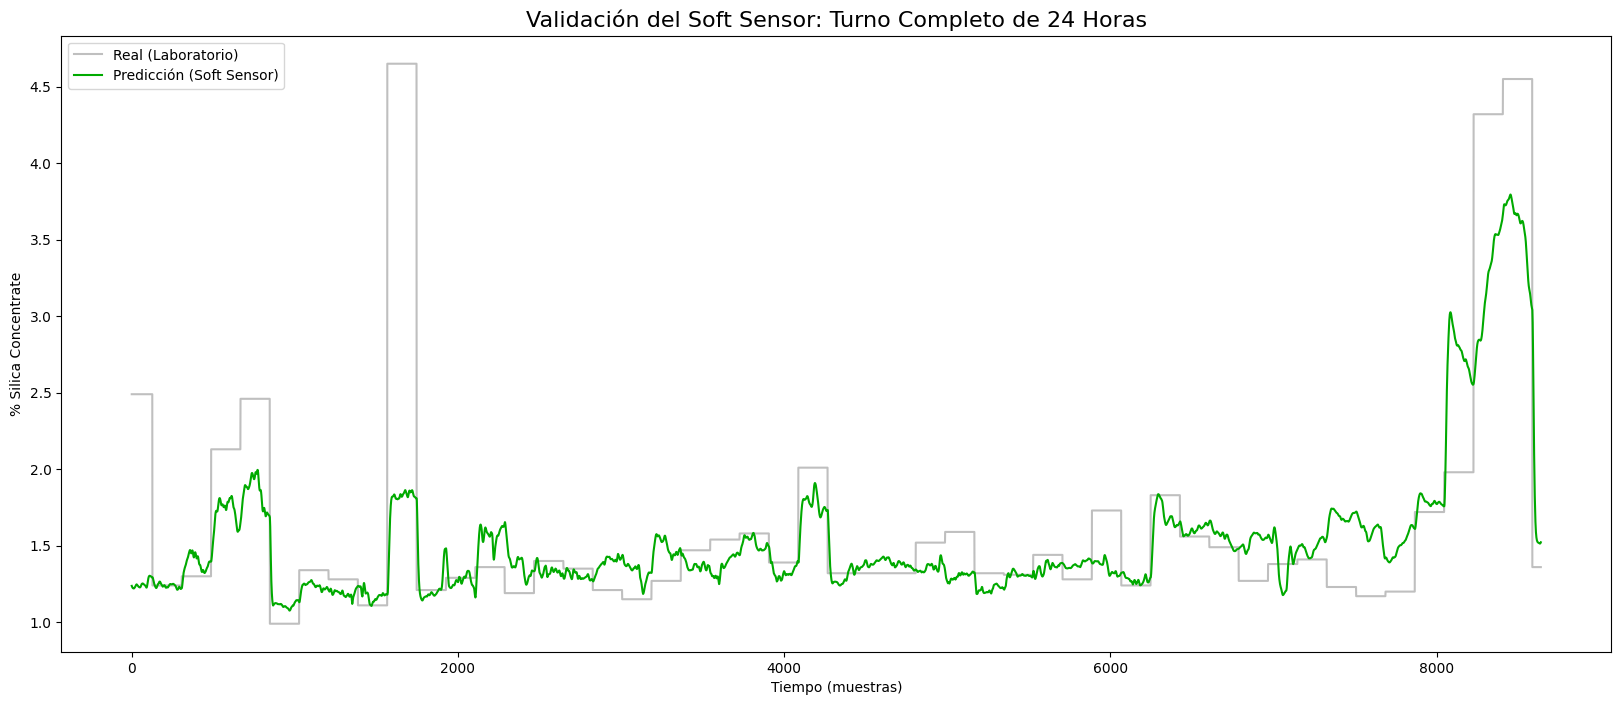

In [25]:
# VISUALIZACIÓN EXTENDIDA (48 HORAS)
plt.figure(figsize=(20, 8))

# Graficamos 48 horas (8640 muestras de 20 seg)
# Si quieres ver TODO, cambia 4320 por len(y_test_real)
limit = 8640

plt.plot(y_test_real[:limit], label='Real (Laboratorio)', color='gray', alpha=0.5)
plt.plot(y_pred_real[:limit], label='Predicción (Soft Sensor)', color='#00aa00', linewidth=1.5)

plt.title(f'Validación del Soft Sensor: Turno Completo de 24 Horas', fontsize=16)
plt.ylabel('% Silica Concentrate')
plt.xlabel('Tiempo (muestras)')
plt.legend()
plt.show()

Mejor ventana de 48h encontrada entre muestras: 1756 y 10395


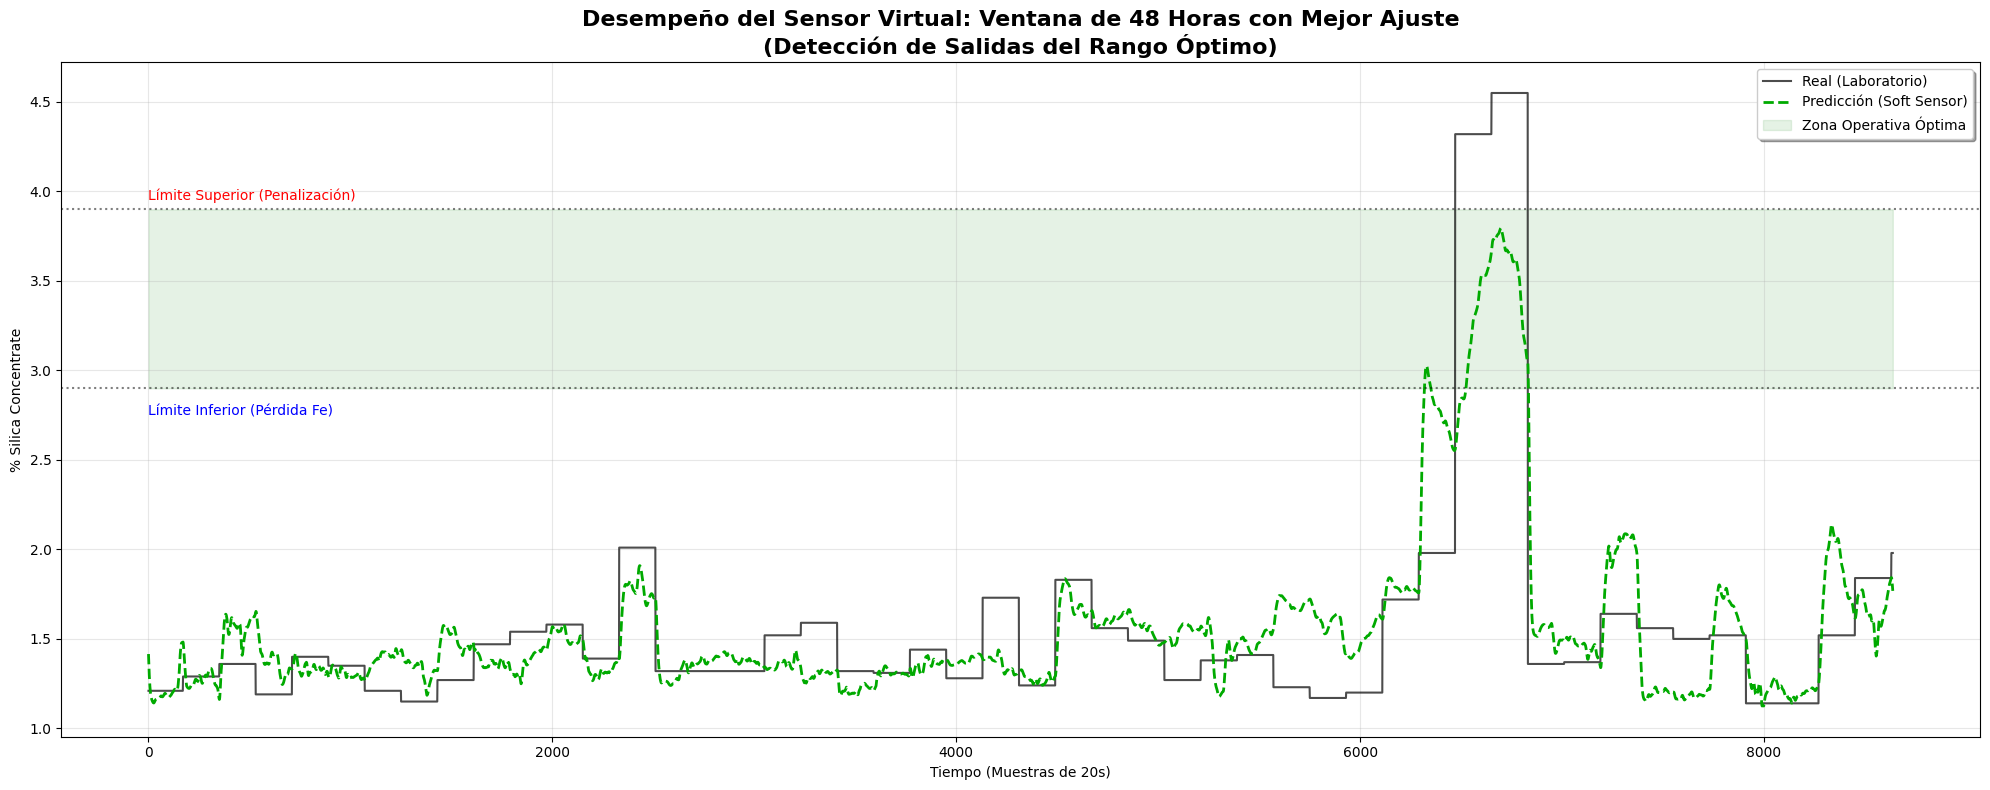

In [26]:
# ==========================================
# 10. VISUALIZACIÓN DE ALTO IMPACTO (SMART PLOTTER)
# ==========================================
import pandas as pd

# 1. Configuración de la Ventana de Tiempo
HOURS_TO_SHOW = 48
SAMPLES_PER_HOUR = 180  # (3 muestras/min * 60 min)
WINDOW_SIZE = HOURS_TO_SHOW * SAMPLES_PER_HOUR

# Límites Operativos
LIM_INF = 2.9
LIM_SUP = 3.9

# 2. Buscador del "Mejor Momento" (Best Fit Finder)
# Calculamos el error cuadrático para cada punto
squared_errors = (y_test_real - y_pred_real) ** 2

# Convertimos a Series de Pandas para usar 'rolling'
# Esto calcula el error promedio móvil de ventanas de 48 horas
rolling_mse = pd.Series(squared_errors.flatten()).rolling(window=WINDOW_SIZE).mean()

# Encontramos el índice donde termina la ventana con MENOR error
best_end_idx = rolling_mse.idxmin()
best_start_idx = best_end_idx - WINDOW_SIZE + 1

print(f"Mejor ventana de {HOURS_TO_SHOW}h encontrada entre muestras: {best_start_idx} y {best_end_idx}")

# 3. Graficar esa ventana específica
plt.figure(figsize=(20, 8))

# Extraer los datos de ese periodo
subset_real = y_test_real[best_start_idx : best_end_idx]
subset_pred = y_pred_real[best_start_idx : best_end_idx]
x_axis = range(len(subset_real)) # Eje X relativo

# Curvas
plt.plot(x_axis, subset_real, label='Real (Laboratorio)', color='black', alpha=0.7, linewidth=1.5)
plt.plot(x_axis, subset_pred, label='Predicción (Soft Sensor)', color='#00aa00', linestyle='--', linewidth=2)

# ZONAS OPERATIVAS (El toque profesional)
# A. Zona de Penalización (> 3.9)
plt.axhline(y=LIM_SUP, color='black', linestyle=':', alpha=0.5)
plt.text(0, LIM_SUP + 0.05, 'Límite Superior (Penalización)', color='red', fontsize=10)

# B. Zona de Pérdida (< 2.9)
plt.axhline(y=LIM_INF, color='black', linestyle=':', alpha=0.5)
plt.text(0, LIM_INF - 0.15, 'Límite Inferior (Pérdida Fe)', color='blue', fontsize=10)

# C. Zona Óptima (Sombreado Verde)
plt.fill_between(x_axis, LIM_INF, LIM_SUP, color='green', alpha=0.1, label='Zona Operativa Óptima')

# Decoración
plt.title(f'Desempeño del Sensor Virtual: Ventana de {HOURS_TO_SHOW} Horas con Mejor Ajuste\n(Detección de Salidas del Rango Óptimo)', fontsize=16, fontweight='bold')
plt.ylabel('% Silica Concentrate')
plt.xlabel('Tiempo (Muestras de 20s)')
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()